![image](https://www.technotification.com/wp-content/uploads/2018/09/Renewable-Energy-Ideas-1200x600.jpg)
Image source: [technotification](https://www.technotification.com/2018/09/amazing-renewable-energy-ideas.html)

This notebook aims to predict a building's energy consumption over 2017 and 2018 using the data from 2016 in 4 different consumpiton categories (electricity, chilled water, steam, hot water) using ASHRAE data, which is our problem statement as well.

This is a supervised machine learning model, meaning based on the columns available in the datasets and data from 2016, we are going to train the model to predict an energy consumption of a building in each category. Since, consumption values are labeled as meter_reading and they are continuous, we are going to apply regression techniques to generate predictions on meter_reading.

It is a highly debated and popular competition in Kaggle currently, however my main motivation is to contribute to make energy-efficient buildings by estimating its energy consumption. It seemed like a good start to save our energy for future!

There will be 3 notebooks covering the complete machine learning building pipeline.

[Notebook 1](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-1-detailed-eda) covered understanding the data and detailed EDA.

This notebook will focus on parts 3, 4 and 5; feature engineering, building the machine learning model and tuning its parameters.


1) Understand, Cleand and Format Data

2) Exploratory Data Analysis

**3) Feature Engineering & Selection**

**4) Compare Several Machine Learning Models**

**5) Perform Hyperparameter Tuning and Cross Validation**

6) Evaluate Model with Test Data

7) Interpret Model Results

8) Submissions & Summary & Conclusions

[Notebook 3](niyim/save-the-energy-for-the-future-3-predictions) will generate the predictions with the selected model in this notebook and interpret them with an overall summary.

Machine Learning application and building is not a linear and one time process. Steps above enable me to follow a structured way for an end-to-end machine project flow and preparation for the each step ahead. All in all, steps might be modified or revisited according to findings. You can use the table of contents to navigate to each section 👇

Enjoy reading !

# <a id='top'> Table of Contents </a>
- <a href='#1'>Quick Recap from the Previous Notebook</a>


- <a href='#3'> 3. Feature Engineering & Selection </a>
  - <a href='#3-1'> 3.1. Feature Generation & Imputation </a>
    - <a href='#3-1-1'> 3.1.1. Building features transformation </a>
      - <a href='#3-1-1-1'> 3.1.1.1. Age from year built </a>
      - <a href='#3-1-1-2'>  3.1.1.2. Primary use  </a>
    - <a href='#3-1-2'> 3.1.2. Weather features transformation </a>
      - <a href='#3-1-2-1'> 3.1.2.1. Add time related data from timestamp </a>
      - <a href='#3-1-2-2'> 3.1.2.2. Impute missing values for weather variables </a>
      - <a href='#3-1-2-3'>  3.1.2.3. Convert wind direction  </a>
    - <a href='#3-1-3'> 3.1.3. Combine numeric features </a>
    - <a href='#3-1-4'> 3.1.4. Merge dataframes </a>
  - <a href='#3-2'> 3.2. Feature Selection & Further Imputation </a>
    - <a href='#3-2-1'> 3.2.1. Pearson coefficients of the features </a>
    - <a href='#3-2-2'> 3.2.2. Imputation of Train Dataset </a>
  - <a href='#3-3'> 3.3. Split train set into training and validation set </a>
  - <a href='#3-4'> 3.4. Create a Baseline Metric </a>


- <a href='#4'> 4. Compare Several Machine Learning Models </a>
  - <a href='#4-1'> 4.1. Linear Regression </a>
  - <a href='#4-2'> 4.2. KNeighbors Regressor</a>
  - <a href='#4-3'> 4.3. Light GBM </a>
  - <a href='#4-4'> 4.4. Setting the initial parameters of light gbm </a>


- <a href='#5-1'> 5. Perform Hyperparameter Tuning on the Best Model </a>
- <a href='#5-2'> 5. Updated on Version10: Perform cross validation on the Light GBM </a>
- <a href='#6'> Conclusions </a>

**Imports:**
I will mainly use scikit-learn library for the machine learning model building and give the light gbm library a try. For the hyperparameter tuning I will use hyperopt.

In [ ]:
# for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# pandas options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.use_inf_as_na', True)
pd.options.mode.chained_assignment = None

# for date manipulation
from datetime import datetime

# for visualization: matplotlib
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
# to display visuals in the notebook

# for visualization: seaborn
import seaborn as sns
sns.set_context(font_scale=2)

# for feature engineering: itertools
from itertools import combinations

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for building the model and calculate RMSE
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# for hyperparamter optimization and the cross-validation search
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import TimeSeriesSplit

# for model explainability
import shap

# to cleanup memory usage
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# load train  data
building = pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv")
weather_train = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_train.csv")
train = pd.read_csv("/kaggle/input/ashrae-energy-prediction/train.csv")

# drop floor_count
building.drop(columns=["floor_count"], inplace=True)

# convert timestamp column of weather_train and train
train["timestamp"] = pd.to_datetime(train["timestamp"],
                                   format='%Y-%m-%d %H:%M:%S')
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"],
                                            format='%Y-%m-%d %H:%M:%S')

In [ ]:
## Function to reduce the DF size
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [ ]:
reduce_memory_usage(building)
reduce_memory_usage(weather_train)
reduce_memory_usage(train)

# <a id='1'> Quick Recap from the Previous Notebook </a>
<a href='#top'> Back to Top </a>

In the previous notebook we had a look at the  distirbution of the target(meter_reading) from various aspects and its relationship of each variable to the meter reading values. Moreover, we observed distribution, missing values and time-series plot of each individual feature.

**Here is the distribution of the natural logarithm of the meter reading+1 among different meter categories:**

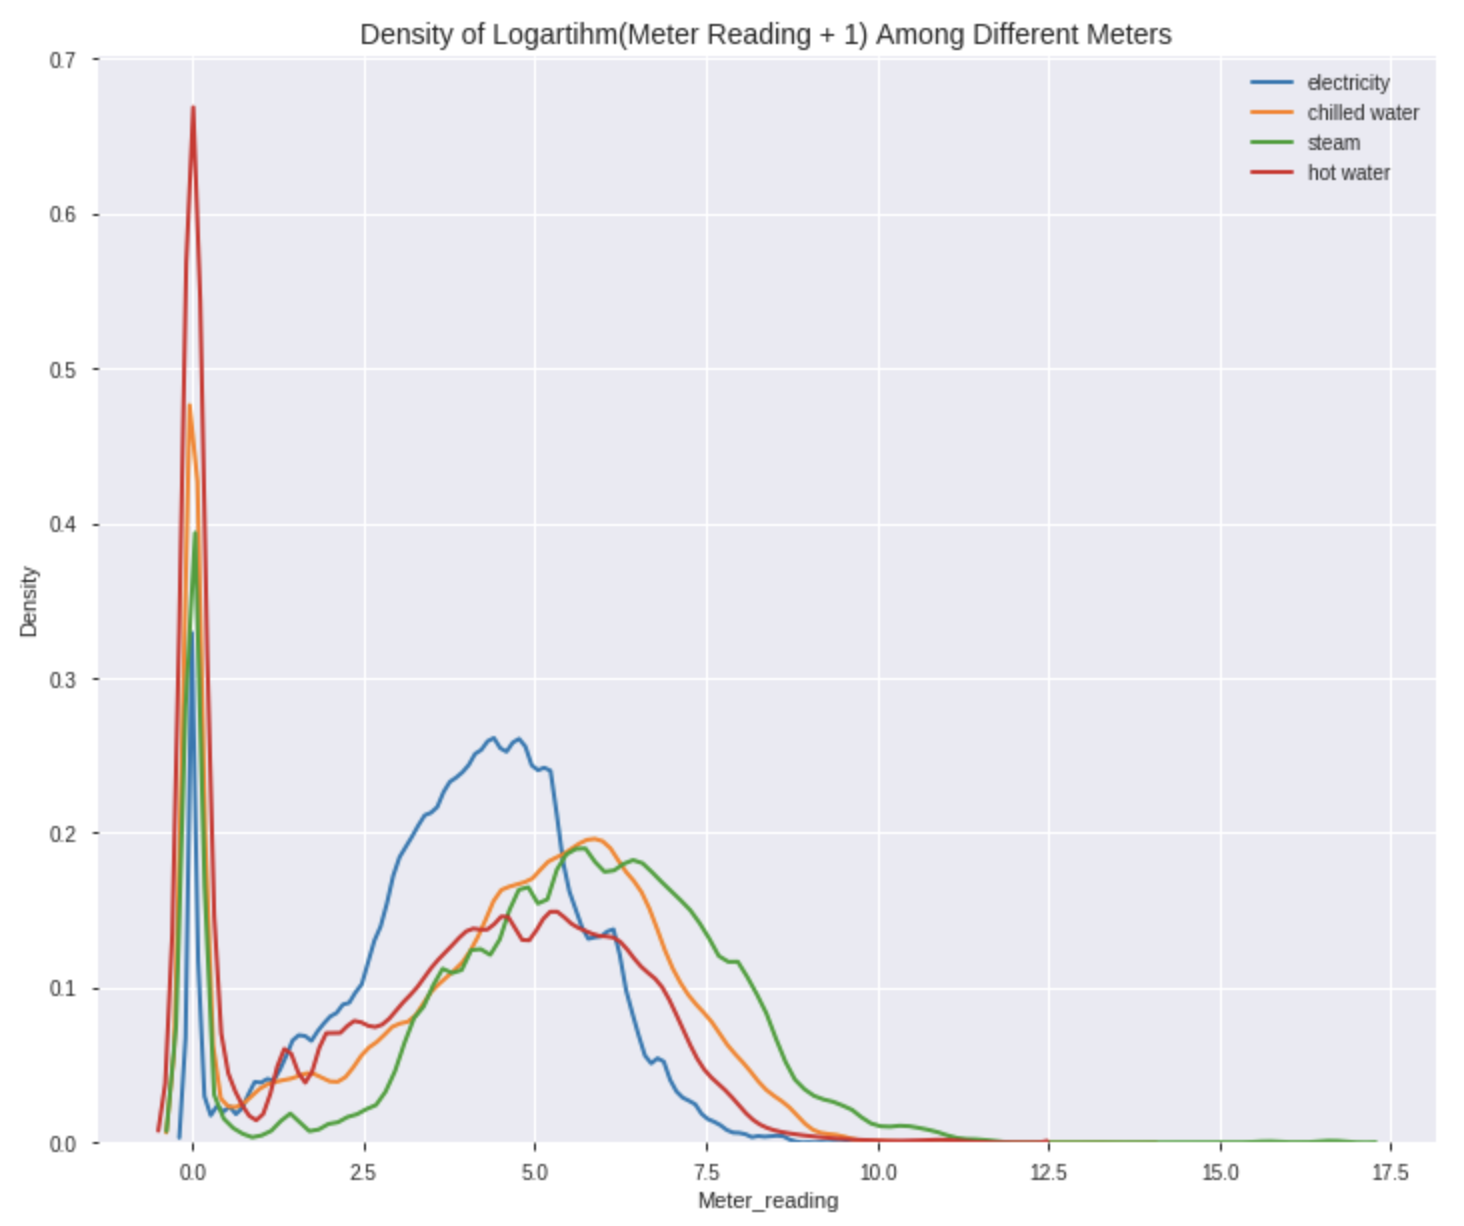

The training data from 2016 has 20 million rows, and using that data we are going to predict 40 million rows of 2017 and 2018 data in different meter categories. 

There are 15 columns to use as a potential feature set. Some features highly impacting the energy consumption, like square_feet and air_temperature. However, some are not that much significant. 

If a not-signifciant column has also high missing values like floor_count, it will be dropped. Others will be transformed into categorical features (like wind_direction). Other weather data will be used for feature generation.

# <a id='3'> 3. Feature Engineering & Selection </a>
<a href='#top'> Back to Top </a>

In this part, using the findings from the EDA and with some human interpretation, I will generate more features. 

Adding and extracting more features based on the existing ones and deciding on which ones to use whether with an algorithm or by manual selection using the human or domain knowledge is called feature enegineering. (definition from wikipedia is [here](https://en.wikipedia.org/wiki/Feature_engineering)).

Some common options for feature engineering:
* automatic tools like [featuretools](https://www.featuretools.com/): this does all the process defined for us, and I gave it a shot to use in this project. I guess due to the amount of data we have, I faced some runtime errors.
* transformations of numerical columns: by taking the logarithm and square root
* transformation of categorical columns: with several encoding techniques
* combination of numeric features: by creating linear combinations of the numeric features
* manual approach: looking at the definitions of the features and by understanding the relationship between them
<br> I will follow the manual and combination approach 👆</br>

We have 15 unique columns in all three train datasets. I think 15 is a relatively low number for a feature set if we think that we have 40 million rows to predict in the test set. Using very few features might end up in underfitting.

Moreover, when I search my own ML notes, here is the one of the valuable learnings I got from Andrew Ng's Machine Learning course is (quoting from my personal notes):

> To get a low test error, use algorith with many features. This will ensure to create a low-bias algortihm. On the other hand, if you feed your algorith with a very large training set you will lower the variance. This way you can balance out the bias and variance, increasing the probablity of getting a low test error model.

So, for this specific project, I am going to impute each dataset first then add and transform features:

* tranformation numerical features into categorical
  * wind_direction
  * primary_use
* extract features from existing columns
  * from year_built
    * age of the building
  * from timestamp
    * month
    * hour
    * day of the month
    * day of the week
    * is_weekend
    * season
* combine numeric features
  
Moreover, I will try a different approach and impute the missing values at the same time with the feature generation before merging the 3 train data frames.

Moreover, I will change imputing strategy to mean, meaning:
- for the building dataset I will impute the columns with the mean
- for the weather_train dataset I will imputer each weather variable with the daily mean for that month of the measurements in each site

After the generation and imputing, I will look at the pearson coefficients of the features to the target and look at the [collinearity](https://en.wikipedia.org/wiki/Multicollinearity) (to be discussed later on!) between the features to decide on the final set.

## <a id='3-1'>  3.1. Feature Generation & Imputation </a>
<a href='#top'> Back to Top </a>

### <a id='3-1-1'> 3.1.1. Building features transformation </a>
<a href='#top'> Back to Top </a>

When we are loading the datasets, I dropped floor_count due to the 75% of the data is missing. For the building dataset, I am going to convert year_built to age column as I did for the visualization case and impute missing values of the building_age with the mean.

And I will tranform the primary_use column to a numeric column by using one of the encoding strategies.

#### <a id='3-1-1-1'> 3.1.1.1. Age from year built </a>
<a href='#top'> Back to Top </a>

We observed that when we transform year_built values it will scale it to 0 to 120 which bring better intepretability to our model. 

After adding age I am going to drop year_built because they are providing the same information to the model. As a final step, I will fill missing values with the mean.

In [ ]:
# add building age column
current_year = datetime.now().year
building['building_age'] = current_year - building['year_built']
building.drop(columns=['year_built'], inplace=True)

# since NA values only present in building age fillna can be used
building.fillna(round(building.building_age.mean(),0),
                inplace=True)

In [ ]:
# check if any NA values left
building.isna().sum()

#### <a id='3-1-1-2'>  3.1.1.2. Primary use  </a>
<a href='#top'> Back to Top </a>

There are several options for encoding a categorical variable: label encoding, one-hot-encodig, count-encoding and so on. 

I want to have only one column for primary_use, so I am going to keep it simple and go with the label encoding.

In [ ]:
# create label encoder object and transform the column
le = LabelEncoder()
le_primary_use = le.fit_transform(building.primary_use)

# add label encoded column to dataframe
building['primary_use'] = le_primary_use

del le, le_primary_use
gc.collect()

### <a id='3-1-2'> 3.1.2. Weather features transformation </a>
<a href='#top'> Back to Top </a>

#### <a id='3-1-2-1'> 3.1.2.1. Add time related data from timestamp </a>
<a href='#top'> Back to Top </a>

Recall that we found some seasonality factors in the time-series data especially for the chilled and hot water consumption.
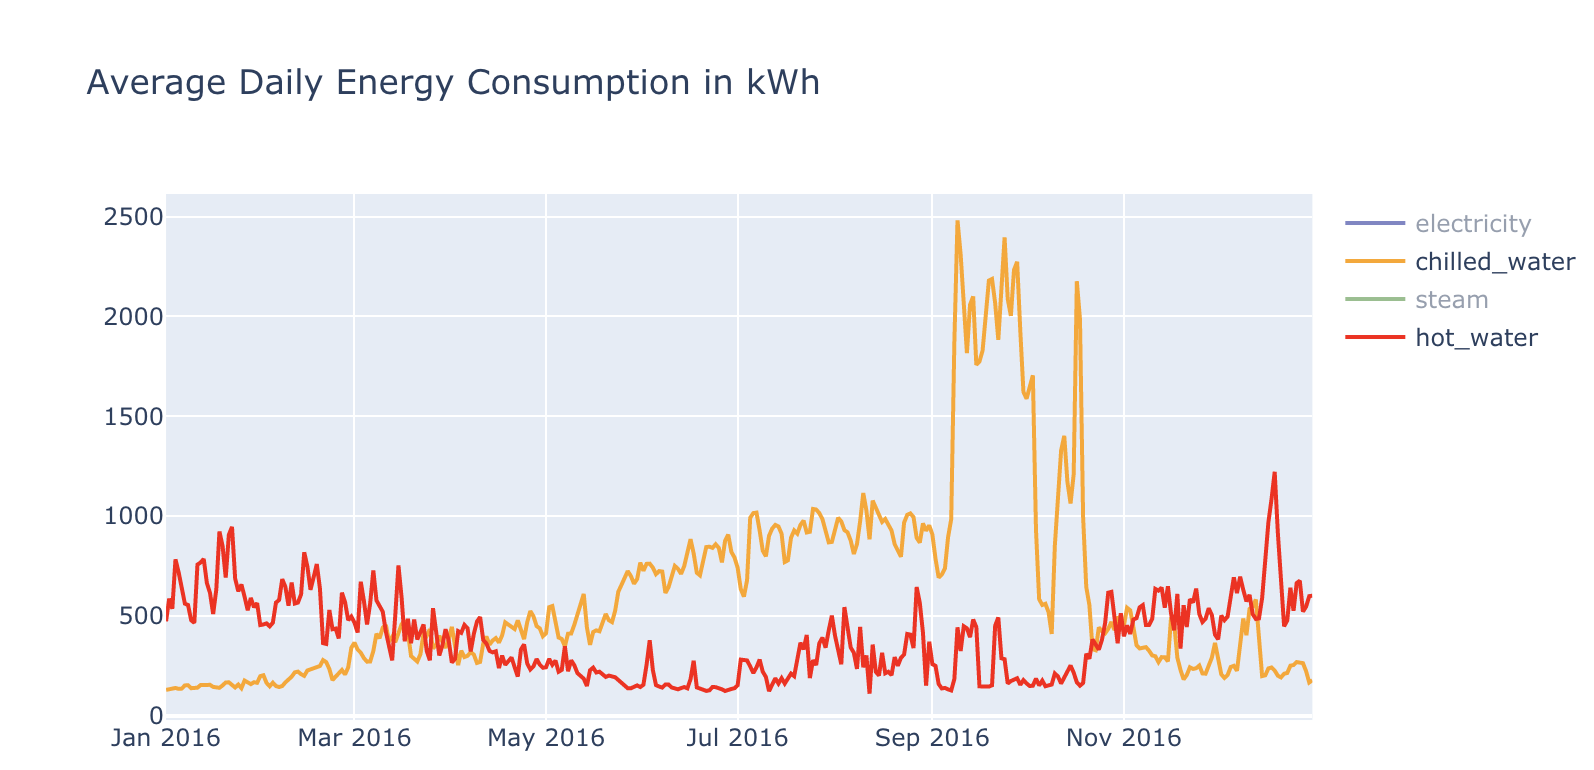

Fetching month, day of the week, day of month and hour from the timestamp column will help the model to catch the seasonality impact without using the timestamp column when training the model.

Additionally, I will add is_weekend and season (winter, spring, summer and fall) to emphasize seasonality in the model.

In [ ]:
# add month, day of week, day of month and hour
weather_train['month'] = weather_train['timestamp'].dt.month.astype(np.int8)
weather_train['day_of_week'] = weather_train['timestamp'].dt.dayofweek.astype(np.int8)
weather_train['day_of_month']= weather_train['timestamp'].dt.day.astype(np.int8)
weather_train['hour'] = weather_train['timestamp'].dt.hour

# add is weekend column
weather_train['is_weekend'] = weather_train.day_of_week.apply(lambda x: 1 if x>=5 else 0)

In [ ]:
def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

In [ ]:
weather_train['season'] = weather_train.month.apply(convert_season)

#### <a id='3-1-2-2'> 3.1.2.2. Impute missing values for weather variables </a>
<a href='#top'> Back to Top </a>

We had a quite deal of missing values in the training dataset, except site_id and time_stamp:
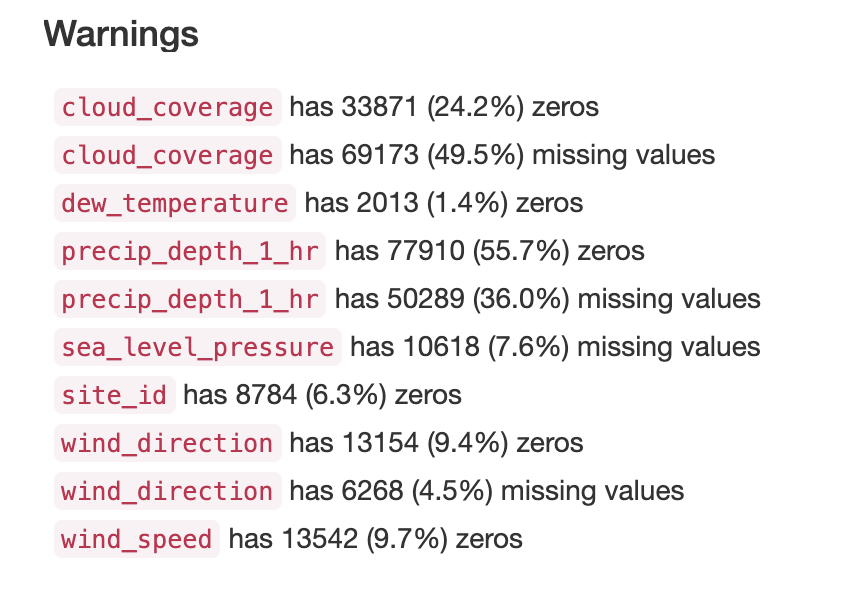

I will impute evey missing data from the daily mean of each site per month. This is the most logical and [proven method](https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08) (so far). For that, I am going to use update function of pandas.

I modified the function from [this notebook](https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08) for imputation. If daily means per month per site_id is not available then I will fill it with the mean values of the filler object created by goruping site_id, day and month.

**Reset Index for Update**

In [ ]:
weather_train = weather_train.set_index(
    ['site_id','day_of_month','month'])

**Air temperature**

In [ ]:
# create dataframe of daily means per site id
air_temperature_filler = pd.DataFrame(weather_train
                                      .groupby(['site_id','day_of_month','month'])
                                      ['air_temperature'].mean(),
                                      columns=["air_temperature"])
air_temperature_filler.isna().sum()

In [ ]:
# create dataframe of air_temperatures to fill
temporary_df = pd.DataFrame({'air_temperature' : weather_train.air_temperature})

# update NA air_temperature values
temporary_df.update(air_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_train["air_temperature"] = temporary_df["air_temperature"]

del temporary_df, air_temperature_filler
gc.collect()

**Cloud Coverage**

In [ ]:
# create dataframe of daily means per site id
cloud_coverage_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['cloud_coverage'].mean(),
                                     columns = ['cloud_coverage'])
cloud_coverage_filler.isna().sum()

There are still NA values, so I will first fill NA values of the filler with the rounded mean value, because cloud_coverage takes discrete values.

In [ ]:
round(cloud_coverage_filler.cloud_coverage.mean(),0)

In [ ]:
cloud_coverage_filler.fillna(round(cloud_coverage_filler.cloud_coverage.mean(),0), 
                             inplace=True)

# create dataframe of cloud_coverages to fill
temporary_df = pd.DataFrame({'cloud_coverage' : weather_train.cloud_coverage})

# update NA cloud_coverage values
temporary_df.update(cloud_coverage_filler, overwrite=False)

# update in the weather train dataset
weather_train["cloud_coverage"] = temporary_df["cloud_coverage"]

del temporary_df, cloud_coverage_filler
gc.collect()

**Dew Temperature**

In [ ]:
# create dataframe of daily means per site id
dew_temperature_filler = pd.DataFrame(weather_train
                                      .groupby(['site_id','day_of_month','month'])
                                      ['dew_temperature'].mean(),
                                      columns=["dew_temperature"])
dew_temperature_filler.isna().sum()

In [ ]:
# create dataframe of dew_temperatures to fill
temporary_df = pd.DataFrame({'dew_temperature' : weather_train.dew_temperature})

# update NA dew_temperature values
temporary_df.update(dew_temperature_filler, overwrite=False)

# update in the weather train dataset
weather_train["dew_temperature"] = temporary_df["dew_temperature"]

del temporary_df, dew_temperature_filler
gc.collect()

**Precip Depth 1 Hour**

In [ ]:
# create dataframe of daily means per site id
precip_depth_filler = pd.DataFrame(weather_train
                                   .groupby(['site_id','day_of_month','month'])
                                   ['precip_depth_1_hr'].mean(),
                                   columns=['precip_depth_1_hr'])
precip_depth_filler.isna().sum()

There are still NA values, so I will first fill NA values of the filler with the rounded mean value (because precip_depth_1_hour takes discrete values), as I did for cloud_coverage.

In [ ]:
round(precip_depth_filler['precip_depth_1_hr'].mean(),0)

In [ ]:
precip_depth_filler.fillna(round(precip_depth_filler['precip_depth_1_hr'].mean(),0)
                           , inplace=True)

# create dataframe of precip_depth_1_hr to fill
temporary_df = pd.DataFrame({'precip_depth_1_hr' : weather_train.precip_depth_1_hr})

# update NA precip_depth_1_hr values
temporary_df.update(precip_depth_filler, overwrite=False)

# update in the weather train dataset
weather_train["precip_depth_1_hr"] = temporary_df["precip_depth_1_hr"]

del precip_depth_filler, temporary_df
gc.collect()

**Sea Level Pressure**

In [ ]:
# create dataframe of daily means per site id
sea_level_filler = pd.DataFrame(weather_train
                                .groupby(['site_id','day_of_month','month'])
                                ['sea_level_pressure'].mean(),
                                columns=['sea_level_pressure'])
sea_level_filler.isna().sum()

There are still NA values, so I will first fill NA values of the filler with the mean value, as I did for cloud_coverage.

In [ ]:
mean_sea_level_pressure = round(
    sea_level_filler
    ['sea_level_pressure']
    .astype(float)
    .mean(),2)

In [ ]:
sea_level_filler.fillna(mean_sea_level_pressure, inplace=True)

# create dataframe of sea_level_pressure to fill
temporary_df = pd.DataFrame({'sea_level_pressure' : weather_train.sea_level_pressure})

# update NA sea_level_pressure values
temporary_df.update(sea_level_filler, overwrite=False)

# update in the weather train dataset
weather_train["sea_level_pressure"] = temporary_df["sea_level_pressure"]

del sea_level_filler, temporary_df
gc.collect()

**Wind Direction**

In [ ]:
# create dataframe of daily means per site id
wind_direction_filler = pd.DataFrame(weather_train
                                     .groupby(['site_id','day_of_month','month'])
                                     ['wind_direction'].mean(),
                                     columns=['wind_direction'])
wind_direction_filler.isna().sum()

In [ ]:
# create dataframe of wind_direction to fill
temporary_df = pd.DataFrame({'wind_direction' : weather_train.wind_direction})

# update NA wind_direction values
temporary_df.update(wind_direction_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_direction"] = temporary_df["wind_direction"]

del temporary_df, wind_direction_filler
gc.collect()

**Wind Speed**

In [ ]:
# create dataframe of daily means per site id
wind_speed_filler = pd.DataFrame(weather_train
                                 .groupby(['site_id','day_of_month','month'])
                                 ['wind_speed'].mean(),
                                 columns=['wind_speed'])
wind_speed_filler.isna().sum()

In [ ]:
# create dataframe of wind_speed to fill
temporary_df = pd.DataFrame({'wind_speed' : weather_train.wind_speed})

# update NA wind_speed values
temporary_df.update(wind_speed_filler, overwrite=False)

# update in the weather train dataset
weather_train["wind_speed"] = temporary_df["wind_speed"]

del temporary_df, wind_speed_filler
gc.collect()

In [ ]:
# check if NA values left
weather_train.isna().sum()

**Reset indexes to transfrom weather dataframe to original form**

In [ ]:
weather_train = weather_train.reset_index()

In [ ]:
weather_train.head()

#### <a id='3-1-2-3'>  3.1.2.3. Convert wind direction  </a>
<a href='#top'> Back to Top </a>

Recall that, wind_direction values span between 0 and 365 representing compass direction. I will aggreagte wind_direction values under 0, 1, 2 and 3 each for Northeast, Southeast, Southwest and Northwest directions.

After converting to categorical data, I am going to drop wind_direction column.

In [ ]:
def convert_direction(degrees):
    if degrees <= 90:
        return 0
    # as norteast direction
    elif degrees <= 180:
        return 1
    # as southeast direction
    elif degrees <= 270:
        return 2
    # as southwest direction
    elif degrees <= 360:
        return 3
    # as northwest direction

In [ ]:
weather_train['wind_compass_direction'] = weather_train.wind_direction.apply(convert_direction)
weather_train.drop(columns=['wind_direction'], inplace=True)

### <a id='3-1-3'> 3.1.3. Combine numeric features </a>
<a href='#top'> Back to Top </a>

I am going to add the mean of the numeric weather variables.

In [ ]:
# create list of weather variables
weather_variables = ["air_temperature", "cloud_coverage", "dew_temperature",
                    "precip_depth_1_hr", "sea_level_pressure", "wind_speed"]

In [ ]:
for i, j in combinations(weather_variables, 2):
    train["mean" + i + "_" + j] = (weather_train[i] + weather_train[j]) / 2

### <a id='3-1-4'> 3.1.4. Merge dataframes </a>
<a href='#top'> Back to Top </a>

In [ ]:
# merge dataframes on train dataframe
train = train.merge(building, on = "building_id", how = "left")
train = train.merge(weather_train, on = ["site_id", "timestamp"], how='left')

In [ ]:
del building
del weather_train
del weather_variables
gc.collect()

In [ ]:
print("Number of unique columns in the train dataset:", train.shape[1])

We have 36 columns after the feature generation one of them being the target value: `meter_reading`.

**Lets check again for the null values one more time**

In [ ]:
train.isna().sum()

After the merge we still have some null values, due to the fact that train dataset has more observations than the tweather_train dataset. I am going to keep it as is for now, and impute missing values before creating the ML models.

## <a id='3-2'> 3.2. Feature Selection & Further Imputation </a>
<a href='#top'> Back to Top </a>

There are several methods and algorithms available for feature selection:
* [removing highly collinear features](https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on/43104383#43104383)
* [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [functions in the feature selection class from from scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html)
and so on...

As a quick and dirty solution and to start with I am going to look at pearson coefficients correlations. This is not the best solution for feature selection as it only considers the correlation between one feature to the target, one at a time, rather than considering the consolidated effect of the features to the target.

### <a id='3-2-1'> 3.2.1. Pearson coefficients of the features </a>
<a href='#top'> Back to Top </a>

I am going list how closely related each feature to the target. To do that, I am going to create pearson coefficients dataframe.

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related ([source](https://www.spss-tutorials.com/pearson-correlation-coefficient/)). So as it gets closer to 1 or -1, the correlation gets stronger.

In [ ]:
correlations_transformed = pd.DataFrame(train.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["meter_reading"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with meter_reading"]
corr_df = (correlations_transformed[correlations_transformed["Feature"] != "meter_reading"]
                .sort_values(by="Correlation with meter_reading", ascending=True))
corr_df

Strongest correlation we get is -0.1 and 0.2 which is not as high as I expected. I am going to try looking at the correlations with the natural logarithm of the meter reading+1 using np.log1p. This might help, as it helped for the visualization case.

In [ ]:
del corr_df, correlations_transformed
gc.collect()

In [ ]:
# add log_meter_reading column to the dataframe
train['log_meter_reading'] = np.log1p(train.meter_reading)

In [ ]:
correlations_transformed = pd.DataFrame(train.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["log_meter_reading"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with log_meter_reading"]
corr_df = (correlations_transformed[correlations_transformed["Feature"] != "log_meter_reading"]
                .sort_values(by="Correlation with log_meter_reading", ascending=True))
corr_df

**Some Notes on Collinearity:**
<br> Usually a data scientist don't want highly collinear features going into the model. 

I dropped the original feature if I have generated a new one. There are some collinear features left though from the original dataset: site_id & building_id and air_temperature & dew_temperature.

As both feature sets play a major role determining log_meter_reading values I am going to keep both sets, and add precip_depth_1_hr additionally.

For the feautre selection, if pearson coeffiecient is greater than the absolute value of 0.004, I will keep that feature, and this method includes meter_reading in the feature set so I replace it and include the original feature precip_depth_1_hr.

In [ ]:
initial_feature_list = (corr_df[
    (corr_df["Correlation with log_meter_reading"] >= 0.004) | 
    (corr_df["Correlation with log_meter_reading"] <= -0.004)]["Feature"].
                        to_list())

In [ ]:
#original_feature_set = ['building_age', 'le_primary_use', 'cloud_coverage', 
#                        'is_weekend','wind_speed', 'day_of_week',
#                        'wind_compass_direction', 'sea_level_pressure', 'air_temperature',
#                        'day_of_month', 'dew_temperature', 'hour', 
#                        'month', 'meter', 'building_id', 
#                        'site_id', 'square_feet']

In [ ]:
# we included meter_reading in the initial feature set
# which is not a feature
# replace meter_reading with precip_depth_1_hr
for n, i in enumerate(initial_feature_list):
    if i == "meter_reading":
        initial_feature_list[n] = "precip_depth_1_hr"
initial_feature_list

In [ ]:
del corr_df, correlations_transformed
gc.collect()

In [ ]:
X = train[initial_feature_list]
y = train['log_meter_reading']

In [ ]:
print("Pearson coefficient based feature selection leaves us with {} features.".
      format(len(X.columns)))

In [ ]:
del train
gc.collect()

### <a id='3-2-2'> 3.2.2. Imputation of Train Dataset </a>
<a href='#top'> Back to Top </a>

Recall that, although I performed imputation on the train datasets individually we still have some NA values in the training dataset. None of the machine learning models can work with NA values, I am going to replace NA values. To replace I am going to use [fillna function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) for simplicity and to avoid data leakage. With this method  propagate last valid observation forward to next valid backfill.

This isa benefical point because, it prevents future data leaking into the training dataset. Preventing data leakage is important in a way [defined](https://machinelearningmastery.com/data-leakage-machine-learning/) by the machine learning mastery as follows:
> Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the model being constructed.

In [ ]:
X = X.fillna(method='ffill', axis=1)

In [ ]:
X.isna().sum()

## <a id='3-3'> 3.3. Split train set into training and validation set </a>
<a href='#top'> Back to Top </a>

Now we are going to split the training set into train and validation set.

**Training set** will be used to for the model to learn and capture the patterns and relate them to the target.
<br> **Validation set** will be used for to understand how well the model generalizes learnings and captures to the newly introduced datasets. 

The score of the evaluation metric obtained from the validation set can be an indicator of the test error.

I removed the timestamp column but it is still a time series data, meaning it has its own trends and seasonality factors. If this dataset was time independent, scikit-learn's train_test_split can be applied straightforward, but I want to keep my training and validation set sequential during the split.

So, I am going to use custom approach and split train and validation set as below. This way, I am going to keep first 75% of the columns as training set and last quarter will be validation set.

In [ ]:
# split train and validation set into 75 and 25 percent sequentially
X_train = X[:int(3 * X.shape[0] / 4)]
X_valid = X[int(3 * X.shape[0] / 4):]

y_train = y[:int(3 * y.shape[0] / 4)]
y_valid = y[int(3 * y.shape[0] / 4):]

In [ ]:
# make sure train and validation sets shape align
print("Shape of the training set is: ", X_train.shape)
print("Shape of the validation set is: ", X_valid.shape)
print("Shape of the training labels are: ", y_train.shape)
print("Shape of the validation labels are: ", y_valid.shape)

## <a id='3-4'> 3.4. Create a Baseline Metric </a>
<a href='#top'> Back to Top </a>

Before diving deep into the ML algorithms, I am going to calculate a common sense baseline. A common sense baseline is defined in this [article](https://towardsdatascience.com/first-create-a-common-sense-baseline-e66dbf8a8a47) in simple terms, how a person has a knowledge in that field would solve the problem without using any data science tricks. Alternatively, as explained in this [post](https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/), it can be a dummy or simple algorithm, consisting of few lines of code, to use as a baseline metric.

Baseline metrics can be [different](https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/) in regression and classification problems. For a regression problem it can be a central tendency measure as the result for all predictions, such as the mean or the median.

Since this a regression problem and competition's results will be [evaluated](https://www.kaggle.com/c/ashrae-energy-prediction/overview/evaluation) for root mean squared logarithmic error, 

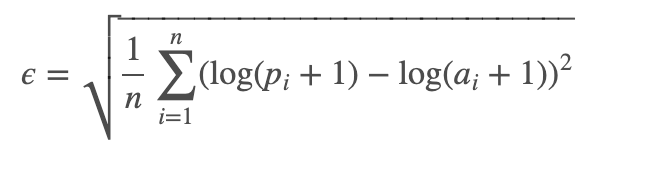

Baseline metrics are important in a way that, if a ML model cannot beat the simple and intuitive prediction of a person's or an algorithm's guess, the original problem needs reconsideration or training data needs reframing.

I have already applied log1p transformation to the target so throughout the project I am going to use RMSE (root mean squared error) as the single evaluation metric, which is:

![image.png](https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png)

I am aware that those metrics are not the same, however I already decreased the variance in the target by applying log1p, and I expect a machine learning model to generate predictions within the same ranges as log1p of target. By measuring it with RMSE and predicting log1p of the target, I can get closer results to measuring with RMSLE and target.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            np.square(y_true - y_pred)
        )
    )

In [ ]:
baseline_guess = np.median(y_train)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the valid set: RMSE = %0.4f" % rmse(y_valid, baseline_guess))

In [ ]:
print("Min value of meter_reading is:", y.min())
print("Median value of meter_reading is:", y.median())
print("Max value of meter_reading is:", y.max())

This shows average estimate is 2 points away from the training median in total. Log_meter_reading values are spread between 0 and 17 so RMSE of 2 shows that the average error from a naive method is about 12%. Although this is a pretty high baseline already let's see if any machine learning model can beat that score. 🧐

# <a id='4'> 4. Compare Several Machine Learning Models </a>
<a href='#top'> Back to Top </a>

We did a heavy lifting job until here and faced the challenges of dealing with the big data, failed to use some libraries in feature selection due to the runtime errors. So this showed me that I need some robust algorithms for this project. 

So I will try out three models: a regression model, a distance based model and a tree-based algorithm that can handle big datasets.

I am going to run simple linear regression, k nearest neighbors regressor and a light gradient boosting machine. Light gradient boosting machine already proved its robustness for big data in several notebooks in this competition. Here are some exmaple notebooks here: [Notebook1](https://www.kaggle.com/rohanrao/ashrae-half-and-half/output), [Notebook2](https://www.kaggle.com/isaienkov/lightgbm-fe-1-19).

**Function to evaluate model's performance on train and validation set with RMSLE**

In [ ]:
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return sqrt(mean_squared_error(y_valid, y_predicted))

## <a id='4-1'> 4.1. Linear Regression </a>
<a href='#top'> Back to Top </a>

In [ ]:
%%time
# create model apply fit_evaluate_model
linear_regression = LinearRegression()
lr_rmse = fit_evaluate_model(linear_regression, X_train, y_train, X_valid, y_valid)
print("RMSE of the linear regression model is:", lr_rmse)

Linear regression model guessed almost the same as the baseline model. Let's see how light gbm will perform.

In [ ]:
del linear_regression
del lr_rmse
gc.collect()

## <a id='4-2'> 4.2. KNeighbors Regressor</a>
<a href='#top'> Back to Top </a>

Distance based models requires scaling prior to the applying the model. So specific to k-nearest regressor I am going to apply min_max_scaler from the scikit-learn library.

In [ ]:
# %%time
# create scaler
# scaler = MinMaxScaler()

# apply min_max_scaler to training set and transform training set
# X_train_scaled = scaler.fit_transform(X_train, y_train)

# transform validation set
# X_valid_scaled = scaler.transform(X_valid)

# knn_regressor = KNeighborsRegressor()
# knn_rmse = fit_evaluate_model(knn_regressor, X_train_scaled, y_train, X_valid_scaled, y_valid)
# print("RMSE of the k nearest neighbors regressor is:", knn_rmse)

It took more than 10 mins to run k-nearest neighbors regressor and it did not generated any results, so I am going to skip that algorithm. 

## <a id='4-3'> 4.3. Light GBM </a>
<a href='#top'> Back to Top </a>

In [ ]:
%%time
# create model apply fit_evaluate_model
lgbm_regressor = lgb.LGBMRegressor(random_state=42)
lgbm_rmse = fit_evaluate_model(lgbm_regressor, X_train, y_train, X_valid, y_valid)
print("RMSE of the light gbm regressor is:", lgbm_rmse)

In [ ]:
del lgbm_regressor
del lgbm_rmse
gc.collect()

We achieved an improvement compared to linear regression. Linear regression yielded 1.98 of RMSE whereas light GBM's RMSE was 1.44. So, I will continue further tuning and adjusting the light gbm to achieve less RMSE.

Linear regression resulted in worse RMSE in less runtimes. Distance based algorithm had the highest run time. Light gbm has the highest run time, but generated the best result so far. This results are a concrete example that supports Rachel Tatman's (@rctatman) summary table of the machine learning algorithm's performances from [PyCon 2019](https://youtu.be/qw5dBdTXLEs?t=1372).

So let's start some tuning!

## <a id='4-4'>  4.4. Setting the initial parameters of light gbm </a>
<a href='#top'> Back to Top </a>

As light GBM outperformed linear regression, let's set some initial parameters for the algorithm. One note is that, when categorical features are specifically specified, light GBM works better. I am going to treat some of the numeric features as categorical features. Here is how more categorical features work better in light gbm implementation:

> LightGBM offers good accuracy with integer-encoded categorical features. LightGBM applies Fisher (1958) to find the optimal split over categories as described here. This often performs better than one-hot encoding.

A good summary and how Light GBM works can be found in this [blog post](https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d), which I also benefitted a lot for this project. Let's move to the implementation.

To decide on the inital parameters, I used the ones in this [notebook](https://www.kaggle.com/rohanrao/ashrae-half-and-half/output).

In [ ]:
# create categorical features 
categorical_features = ['building_id', 'site_id', 'meter',
                        'primary_use', 'wind_compass_direction',
                        'day_of_week', 'hour','is_weekend', 'season']

Now we have 15 numerical features and 9 categorical features to implement.

Here is the definition of the initially set parameters from the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html):

**LGBM train Parameters:**
* `feature_fraction`: randomly selected part of features on each iteration (tree) (default=1) 
* `num_boost_round`: Number of boosting iterations (default=100)
* `boosting`: traditional Gradient Boosting Decision Tree
* `num_leaves`: max number of leaves in one tree (default=31), to control tree complexity
* `learning_rate`: the rate at which the model learning from the train set and achieving the best results (default=0.1), together with num_leaves used to control overfitting and underfitting
* `reg_lambda`: parameter to apply L2 regularization (default=0)

In [ ]:
# tranform training and validation set into lgbm datasets
train_dataset = lgb.Dataset(X_train, label=y_train, 
                            categorical_feature=categorical_features, 
                            free_raw_data=False)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, 
                            categorical_feature=categorical_features, 
                            free_raw_data=False)

# to record eval results for plotting
evals_result = {} 

# initial parameters of light gbm algorithm
initial_params = {"objective": "regression",
                  "boosting": "gbdt",
                  "num_leaves": 60,
                  "learning_rate": 0.05,
                  "feature_fraction": 0.85,
                  "reg_lambda": 2,
                  "metric": {'rmse'}
}

In [ ]:
print("Building model with first 3 quarter pieces and evaluating the model on the last quarter:")
lgb_model = lgb.train(initial_params, 
                      train_set = train_dataset, 
                      num_boost_round = 1000, 
                      valid_sets=[train_dataset, valid_dataset],
                      verbose_eval = 100,
                      early_stopping_rounds = 500,
                      evals_result=evals_result)

In [ ]:
print('Training and Validation Error of the Model')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

In the initial round we started with the 1.31 RMSE of the validation error, and in the final iteration we received 1.19 RMSE for the validation set, 0.12 point decrease, which is a 9 percent improvement overall.

Training error decreased more rapidly through the iterations from 0.95 to 0.68, 0.27 point decrease. This shows that the model learns faster from the training set and this is a consequence of model is trained with the same set of training set in every iteration.

We learned one thing from the initial parameter set round and the iterations: 

* Both training and validation errors decreased, so if I set the num_boost rounds to a higher number, I would probably achieve less RMSE in the cost of higher runtimes. 
* Gap between training and validation error increased, so this is a sign of we are overfitting, to eliminate the possibility of overfitting I will introduce cross-validation into the model rather than hyperparameter tuning.

In [ ]:
del lgb_model
del train_dataset
del valid_dataset
del X_train
del X_valid
del y_train
del y_valid
gc.collect()

# <a id='5-2'> 5. Updated on Version 10: Perform Cross Validation on the Best Model </a>
<a href='#top'> Back to Top </a>

Cross validation allows the model to iteratively run on the different portions of the training set. 

Recall that, I initially manually split train and test split into 4 pieces, allocated first 3 quarters as training set and last quarter as validation set.

Now, I am going to iteratively run the model on the 75% of the training data and see if RMSE will improve.

I am going to use [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), and split X to 4 pieces and run light GBM iteratively on the each fold. 

Here is a quick visual from scikit-learn's website of how Kfold performs splits:
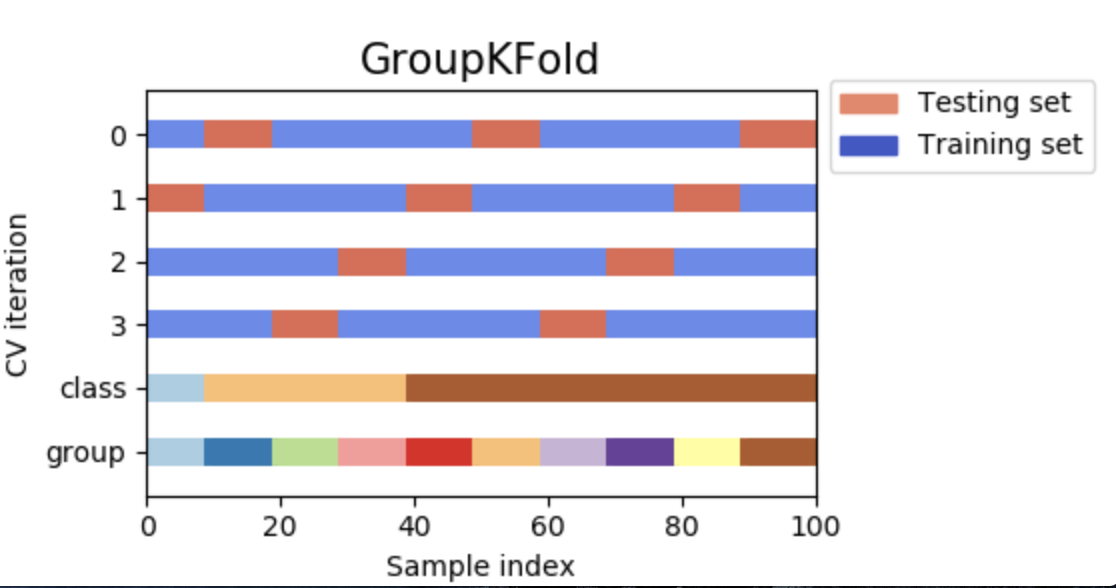

In [ ]:
# add back to train and validation sets
# X = pd.concat([X_train, 
#              X_valid])

#y = pd.concat([y_train,
#               y_valid])

In [ ]:
# cretae kfold object and empty model and evaluation lists
kf = KFold(n_splits=4, shuffle=False, random_state=42)
models = []
evaluations = []

# dynamically split X and y with the k-fold split indexes
for train_index,valid_index in kf.split(X):
    X_train_kf = X.loc[train_index]
    y_train_kf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_kf, 
                          label=y_train_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    d_valid = lgb.Dataset(X_valid_kf, 
                          label=y_valid_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    evaluation_result = {}
    
    model = lgb.train(initial_params, 
                      train_set=d_train, 
                      num_boost_round=1000, 
                      valid_sets=[d_train, d_valid],
                      verbose_eval=100, 
                      early_stopping_rounds=500,
                      evals_result=evaluation_result)
    
    models.append(model)
    evaluations.append(evaluation_result)
    
    del X_train_kf, y_train_kf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

After performing the cross validation the lowest RMSE is 1.06, overall resuting in avearge RMSE of 1.12. So in the last notebook I will perform cross_validation on the model then generate the predictions.

In [ ]:
print('Training and Validation Error of the First Fold')
ax = lgb.plot_metric(evaluations[0], metric='rmse')
plt.show()

In [ ]:
print('Training and Validation Error of the Second Fold')
ax = lgb.plot_metric(evaluations[1], metric='rmse')
plt.show()

In [ ]:
print('Training and Validation Error of the Third Fold')
ax = lgb.plot_metric(evaluations[2], metric='rmse')
plt.show()

In the above folds the gap between the training and validation RMSE is less than the first model built without cross validation. So as we intorduced different training sets, model learned better to interpret the newly intorduced datasets.

# <a id='5-1'> 5. Perform Hyperparameter Tuning on the Best Model </a>
<a href='#top'> Back to Top </a>

Searching and setting the best and optimal set of parameters for a machine learning model can be defined as hyperparameter tuning. In my previous projects I used [random search](https://en.wikipedia.org/wiki/Random_search) and [grid search](http://) algorithms but in this project I am going to try [hyperopt library](https://github.com/hyperopt/hyperopt), a library built for performing the hyperparameter tuning. Here is a good [notebook](https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt) on understanding how hyperopt works.

I will define a search space for the parameters to be fine tuned, the objective -the evaluation metric that I am trying to decrease so far- and run the optimization function and let hyperopt to suggest me the best parameters.

The features that I am going to tune is:

* Num_leaves: since this is discrete integer values, `hp.choice` will be used and sequential space of 60, 62, .., 128, 130 will be searched.
* col_sample_by_tree is the equivalent parameter of the feature_fraction in the previously trained model.
* Learning rate & (col_sample_by_tree): since they are continuous float values, `hp.uniform` will be used:
  * Real numbers between 0.01 to 1 will be seacrhed
  * Real numbers between 0.8 to 1.0 will be searched respectively.
* Reg_lambda kept constant for this search.
* Default value for boosting_type is 'gdbt', so I am not going to specify it explicitly.


Adjudting num_leaves and learning rate together helps to control the trade-off between underfit and overfit. [Notebook](https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt) contains a handy function already for a light gbm model, I am going to implement and modify it according to my objectives.

In [ ]:
'''# objective function to optimize
def objective(params):
    # parameters to perform search
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.2f}'.format(params['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(params['learning_rate'])}
    
    # model and parameters to kept constant
    lgb_model = lgb.LGBMRegressor(
        reg_lambda= 2,
        **params,
        random_state=42)
    
    score = fit_evaluate_model(lgb_model, X_train, y_train, X_valid, y_valid)
    print("RMSE is {:.4f} with parameters {}".format(score, params))
    return score

# define search space
space = {
    'num_leaves': hp.choice('num_leaves', range(60, 130, 2)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1)
}

SEED = 42
# best model with the hyperopt
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            rstate= np.random.RandomState(SEED))'''

So the best iteration we get is with the parameters:

* num_leaves: 106
* colsample_bytree: 0.99
* learning_rate: 0.075
Let's update our initial parameters, and see if we can lower training and validation RMSE.

Surprisingly, the hyperparameter search's parameters did not result in lower RMSE both for training and validation set. So maybe we already found the optimal model with the selected features and initial parameters.

So I am going to use the inital parameters specified in the 4.5. Setting the initial parameters of light gbm while generating the predictions.

# <a id='6'> Conclusions </a>
<a href='#top'> Back to Top </a>

This is the end of the second notebook, if you are still with me, thank you for your patience 😇

In this notebook I covered:

3. Feature Engineering & Selection
4. Compare Several Machine Learning Models
5. Perform Hyperparameter Tuning on the Best Model

using the findings of the [first notebook](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-1-detailed-eda/notebook#--Conclusions-).

With the feature engineering we generated useful features with intuition and combination of numeric features.

Light GBM proved its robustness when working with a large dataset, outperformed linear regression and selected as best model. Thanks to the public notebooks available I was able to start from a good place and lower the RMSE from 1.45 to 1.2 with the initial parameters set. Thank you all Kagglers, for the collaboration!

I also used this as a chance to explore light GBM library. After tuning the parameters of light GBM, I used hyperopt library to perform hyperparameter tuning. It can be an alternative to Grid Search as it performs more comprehensive search. When the model is introduced with cross validation, average validation error is decreased to 1.1, so in the next notebook model will be cross-validated then the predictions will be generated.

Before moving to the third notebook, I faced the challenges of working with 20 million rows all the time. I received runtime errors and ran out of RAM. Morever, some functions did not work (E.g. Simple Imputer) or a distance based model simply ran forever, I had to skip revisiting feature selection.

Keeping there are 40 million rows in the test dataset, we are ready to generate predictions for our supervised regression model. Based on the 30 features and available, training dataset (1 year time-series data) and our light gbm model let's go and find the energy consumption of the buildings for 2017 and 2018.

I will save the features and taget and move on to the next steps, see you on the [third notebook](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-3-predictions) 👋

In [ ]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)